<a href="https://colab.research.google.com/github/Soumyadip3007/ML_DL-Stuffs/blob/main/Feature_Extraction_%26_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
masoudnickparvar_brain_tumor_mri_dataset_path = kagglehub.dataset_download('masoudnickparvar/brain-tumor-mri-dataset')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [ ]:
train_dir='/kaggle/input/brain-tumor-mri-dataset/Training'
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,shuffle=True,seed=123,batch_size=32,image_size=(224,224))

Found 5712 files belonging to 4 classes.


In [ ]:
test_dir='/kaggle/input/brain-tumor-mri-dataset/Testing'
test_dataset=tf.keras.utils.image_dataset_from_directory(test_dir,shuffle=True,seed=123,batch_size=32,image_size=(224,224))

Found 1311 files belonging to 4 classes.


Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']
First few labels: [3 2 3 0 2 1 2 0 3]


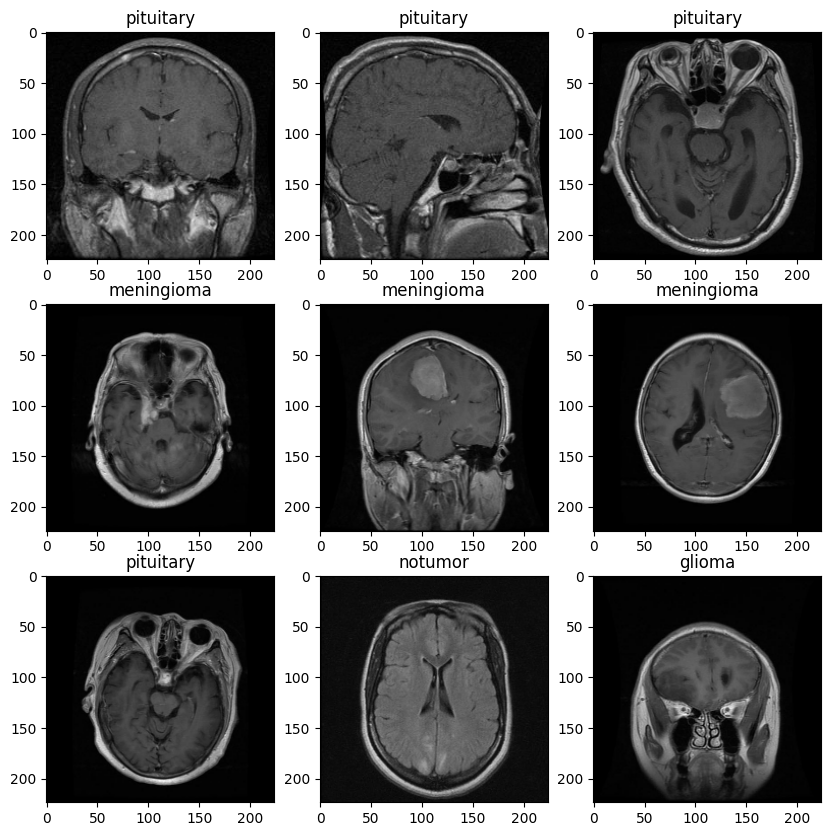

In [ ]:
import matplotlib.pyplot as plt

class_names = train_dataset.class_names

print("Class names:", class_names)
for images, labels in train_dataset.take(1):
    print("First few labels:", labels[:9].numpy())

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        # print(max(images[i].numpy().flatten()))
        plt.title(class_names[labels[i]])
        plt.axis("auto")
plt.show()

In [ ]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


***Dataset pipeline can be optimized by caching and prefetching data:***

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras import Input

In [ ]:
base_model=ResNet50(weights='imagenet',include_top=False,input_tensor=Input(shape=(224,224,3)))

In [ ]:
for layer in base_model.layers:
    layer.trainable=False

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout

x = GlobalAveragePooling2D()(base_model.output)  # ✅ Convert (7,7,2048) → (2048,)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.15)(x)
output = Dense(4, activation=lambda x: tf.nn.softmax(x / 2.0))(x)  # ✅ Fixed softmax smoothing

model = Model(inputs=base_model.input, outputs=output)

In [ ]:
!nvidia-smi

***If GPU supports float16 (FP16 precision), TensorFlow can speed up computations:***

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

**TensorFlow's XLA (Accelerated Linear Algebra) speeds up model execution:**

In [ ]:
import tensorflow as tf
tf.config.optimizer.set_jit(True)  # Enable XLA

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(train_dataset, epochs=20, validation_data=validation_dataset, callbacks=[early_stopping])

Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 92s 444ms/step - accuracy: 0.5010 - loss: 1.1279 - val_accuracy: 0.8441 - val_loss: 0.5018
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 60s 334ms/step - accuracy: 0.7992 - loss: 0.5667 - val_accuracy: 0.8713 - val_loss: 0.3745
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 59s 331ms/step - accuracy: 0.8490 - loss: 0.4238 - val_accuracy: 0.8879 - val_loss: 0.3159
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 59s 329ms/step - accuracy: 0.8596 - loss: 0.3764 - val_accuracy: 0.8949 - val_loss: 0.2873
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 60s 335ms/step - accuracy: 0.8770 - loss: 0.3324 - val_accuracy: 0.8984 - val_loss: 0.2728
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 60s 334ms/step - accuracy: 0.8798 - loss: 0.3244 - val_accuracy: 0.9046 - val_loss: 0.2621
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 60s 333ms/step - accuracy: 0.8928 - loss: 0.2966 - val_accuracy: 0.9098 - val_loss: 0.2481
Epoch 8/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 59s 330ms/step - accuracy: 0.8995 - loss: 0

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 179ms/step - accuracy: 0.9321 - loss: 0.1875
Test accuracy: 0.9214340448379517


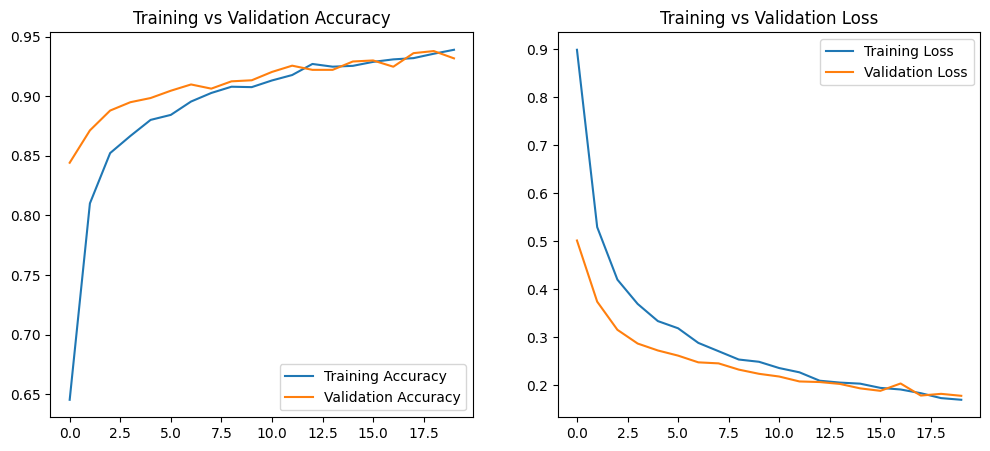

In [ ]:
import matplotlib.pyplot as plt

# Extract values from history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Plot accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


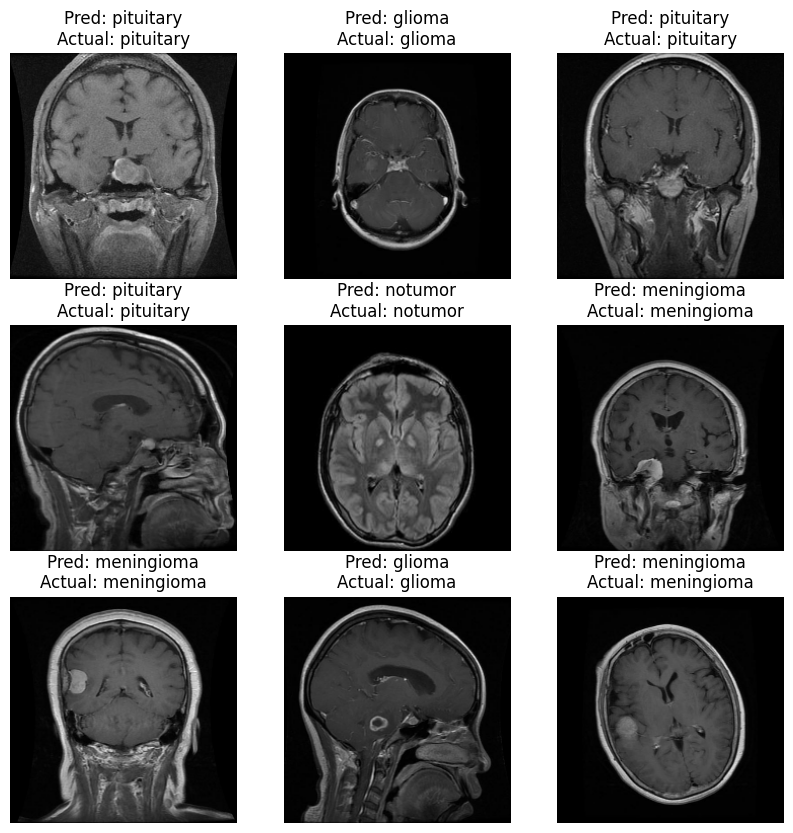

In [ ]:
import numpy as np

# Get a batch of images and labels from test dataset
for test_images, test_labels in test_dataset.take(1):
    predictions = model.predict(test_images)  # Get predictions
    predicted_labels = np.argmax(predictions, axis=1)  # Convert softmax to class index

    # Show results
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Display first 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(test_images[i].numpy().astype("uint8"))
        plt.title(f"Pred: {class_names[predicted_labels[i]]}\nActual: {class_names[test_labels[i]]}")
        plt.axis("off")

    plt.show()
    break  # Only take one batch

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


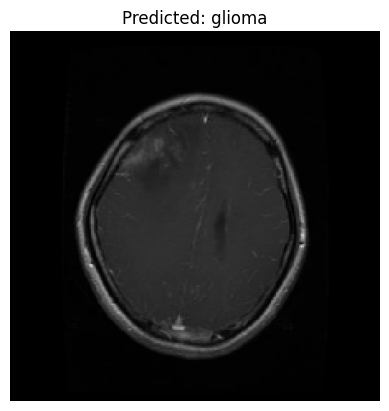

Prediction Probabilities: [[9.99880910e-01 1.08744905e-04 9.40519658e-06 9.61006549e-07]]


In [ ]:
import keras.utils as image

def predict_custom_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize
    img_array = image.img_to_array(img)  # Convert to array
    # img_array = img_array / 255.0  # Normalize (ensure it matches dataset)
    img_array = np.expand_dims(img_array, axis=0)  # Expand dims for batch format

    prediction = model.predict(img_array)  # Get prediction
    predicted_class = np.argmax(prediction)  # Get class index

    plt.imshow(img)
    plt.title(f"Predicted: {class_names[predicted_class]}")
    plt.axis("off")
    plt.show()

    print(f"Prediction Probabilities: {prediction}")  # Debugging: Show softmax scores

# Test with an image
predict_custom_image('/kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-glTr_0002.jpg')

In [ ]:
print(class_names)


['glioma', 'meningioma', 'notumor', 'pituitary']


In [ ]:
import os

train_dir = "/kaggle/input/brain-tumor-mri-dataset/Training"

for category in os.listdir(train_dir):
    path = os.path.join(train_dir, category)
    print(f"{category}: {len(os.listdir(path))} images")

pituitary: 1457 images
notumor: 1595 images
meningioma: 1339 images
glioma: 1321 images
